# detecting cat vs dog using resnet50

In [30]:
import numpy as np 
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator


### loading resnet 50 

### Inpsecting each layer

# re loading model and freezing the top layer 

In [31]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import pickle

# resnet50 was designed to work on 224 x 224 pixel input images sizes
img_rows = 224
img_cols = 224

'''
# Re-loads the resnet50 model without the top or FC layers
resnet_50 = ResNet50(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

# Layers are set to trainable as True by default
for layer in resnet_50.layers:
    layer.trainable = False
    
# Let's print our layers again 
for (i,layer) in enumerate(resnet_50.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)
    
    
# saving resnet50 model without fc layers
import pickle 
pickle_out = open(r"F:\pneumonia\000 P R O J E C T S\models\resnet_50_without_fc.pickle" , 'wb')
pickle.dump (resnet_50 , pickle_out)
pickle_out.close()
'''

# loading model
pickle_in = open(r"F:\pneumonia\000 P R O J E C T S\models\resnet_50_without_fc.pickle"  , 'rb')
resnet_50 = pickle.load (pickle_in)

# Let's print our layers again 
for (i,layer) in enumerate(resnet_50.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)
    

0 InputLayer False
1 ZeroPadding2D False
2 Conv2D False
3 BatchNormalization False
4 Activation False
5 ZeroPadding2D False
6 MaxPooling2D False
7 Conv2D False
8 BatchNormalization False
9 Activation False
10 Conv2D False
11 BatchNormalization False
12 Activation False
13 Conv2D False
14 Conv2D False
15 BatchNormalization False
16 BatchNormalization False
17 Add False
18 Activation False
19 Conv2D False
20 BatchNormalization False
21 Activation False
22 Conv2D False
23 BatchNormalization False
24 Activation False
25 Conv2D False
26 BatchNormalization False
27 Add False
28 Activation False
29 Conv2D False
30 BatchNormalization False
31 Activation False
32 Conv2D False
33 BatchNormalization False
34 Activation False
35 Conv2D False
36 BatchNormalization False
37 Add False
38 Activation False
39 Conv2D False
40 BatchNormalization False
41 Activation False
42 Conv2D False
43 BatchNormalization False
44 Activation False
45 Conv2D False
46 Conv2D False
47 BatchNormalization False
48 BatchNor

C:\Users\Asus\.conda\envs\tf\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [32]:
## Let's make a function that returns our FC Head

In [33]:

#vgg16 top layer
'''
def addTopModel(bottom_model, num_classes, D=32):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""
    top_model = bottom_model.output
    top_model = Flatten(name = "flatten")(top_model)
    top_model = Dense(D, activation = "relu")(top_model)
    top_model = Dropout(0.3)(top_model)
    top_model = Dense(num_classes, activation = "softmax")(top_model)
    return top_model
'''
#mobile net top layer 
def addTopModel(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    #top_model = Flatten(name = "flatten")(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dropout(0.3)(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model


In [34]:
## Let's add our FC Head back onto MobileNet

In [35]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

num_classes = 2

FC_Head = addTopModel(resnet_50, num_classes)

model = Model(inputs=resnet_50.input, outputs=FC_Head)

print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

## loading data 

In [36]:
# path 
train_data = "F:\\pneumonia\\[FreeTutorials.Us] Udemy - Deep Learning Computer Vision\\10. Data Augmentation Build a Cats vs Dogs Classifier\\2.1 datasets.zip\\datasets\\catsvsdogs\\images\\train"
test_data = "F:\\pneumonia\\[FreeTutorials.Us] Udemy - Deep Learning Computer Vision\\10. Data Augmentation Build a Cats vs Dogs Classifier\\2.1 datasets.zip\\datasets\\catsvsdogs\\images\\test"


## data augmentation
batch_size = 10
# what we want 
'''
train_datagen = ImageDataGenerator(
      #rescale=1./255,
      rotation_range=30,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
'''
# resnet required preprocessing
train_datagen = ImageDataGenerator(dtype='float32',
                                   preprocessing_function=preprocess_input)


validation_datagen = ImageDataGenerator(dtype='float32',
                                        preprocessing_function=preprocess_input)
# applying on the data 
train_generator = train_datagen.flow_from_directory(
        train_data,
        #color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)
 
validation_generator = validation_datagen.flow_from_directory(
        test_data,
        #color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

Found 2002 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## call back, checkponts and training

In [37]:
from keras import optimizers
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

                     
checkpoint = ModelCheckpoint(r"F:\pneumonia\000 P R O J E C T S\codes\cat vs dog\resnet_catdog_01.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

# We use a very small learning rate

sgd = optimizers.SGD(lr = 0.001, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(loss = 'categorical_crossentropy',
              optimizer = sgd,
              metrics = ['accuracy'])

nb_train_samples = 2000
nb_validation_samples = 1000
epochs = 5
batch_size = 32

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size
    )

import pickle 
pickle_out = open(r"F:\pneumonia\000 P R O J E C T S\codes\cat vs dog\checkpoint_resnet.pickle" , 'wb')
pickle.dump (checkpoint , pickle_out)
pickle_out.close()

Epoch 1/5
62/62 [==============================] - 94s 2s/step - loss: 0.4064 - accuracy: 0.8226 - val_loss: 0.1021 - val_accuracy: 0.9645

Epoch 00001: val_loss improved from inf to 0.10214, saving model to F:\pneumonia\000 P R O J E C T S\codes\cat vs dog\resnet_catdog_01.h5
Epoch 2/5
62/62 [==============================] - 90s 1s/step - loss: 0.1895 - accuracy: 0.9216 - val_loss: 0.0114 - val_accuracy: 0.9903

Epoch 00002: val_loss improved from 0.10214 to 0.01137, saving model to F:\pneumonia\000 P R O J E C T S\codes\cat vs dog\resnet_catdog_01.h5
Epoch 3/5
62/62 [==============================] - 94s 2s/step - loss: 0.1307 - accuracy: 0.9516 - val_loss: 0.1291 - val_accuracy: 0.9645

Epoch 00003: val_loss did not improve from 0.01137
Epoch 4/5
62/62 [==============================] - 91s 1s/step - loss: 0.1307 - accuracy: 0.9565 - val_loss: 0.0447 - val_accuracy: 0.9806

Epoch 00004: val_loss did not improve from 0.01137
Epoch 5/5
62/62 [==============================] - 93s 2s/

In [90]:
#confusion matrix

Found 1000 images belonging to 2 classes.
Confusion Matrix
[[492   8]
 [  7 493]]
Classification Report
              precision    recall  f1-score   support

         cat       0.99      0.98      0.98       500
         dog       0.98      0.99      0.99       500

    accuracy                           0.98      1000
   macro avg       0.99      0.98      0.98      1000
weighted avg       0.99      0.98      0.98      1000



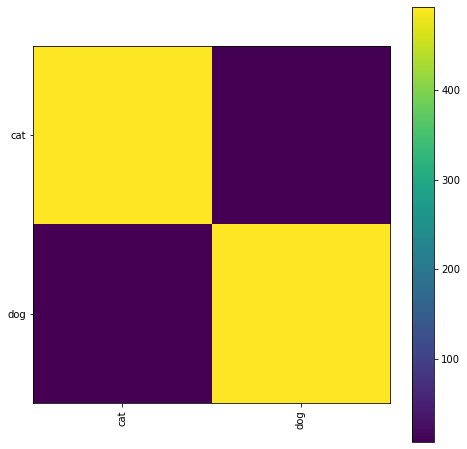

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from keras.models import load_model
import pickle 


# loading model
pickle_in = open(r"F:\pneumonia\000 P R O J E C T S\codes\cat vs dog\checkpoint.pickle" , 'rb')
model = pickle.load (pickle_in)

img_row, img_height, img_depth = 224,224,3
model = load_model(r'F:\pneumonia\000 P R O J E C T S\codes\cat vs dog\resnet_catdog_01.h5')

# We need to recreate our validation generator with shuffle = false
validation_generator = validation_datagen.flow_from_directory(
        test_data,
        #color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

#nb_train_samples = 2000
#nb_validation_samples = 1000


#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

In [39]:
## plots

In [ ]:
# Loss Curves
plt.figure(figsize=[10,8])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.grid()
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.grid()
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16);

In [92]:
# test

In [21]:
#loading model and getting class labels

In [26]:
from keras.models import load_model
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from keras.models import load_model
import pickle 


pickle_in = open(r"F:\pneumonia\000 P R O J E C T S\codes\cat vs dog\checkpoint.pickle" , 'rb')
model = pickle.load (pickle_in)

img_row, img_height, img_depth = 224,224,3
model = load_model(r'F:\pneumonia\000 P R O J E C T S\codes\cat vs dog\resnet_catdog_01.h5')


## getting our class labels 
test_data = "F:\\pneumonia\\[FreeTutorials.Us] Udemy - Deep Learning Computer Vision\\10. Data Augmentation Build a Cats vs Dogs Classifier\\2.1 datasets.zip\\datasets\\catsvsdogs\\images\\test"
validation_datagen = ImageDataGenerator(dtype='float32',
                                        preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
        test_data,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)


class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())
print(class_labels)



Found 1000 images belonging to 2 classes.
{0: 'cat', 1: 'dog'}


In [41]:
from keras.preprocessing import image
import numpy as np
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
import re

def draw_test(name, pred, im, true_label):
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 160, 0, 0, 500 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, "predited - "+ pred, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.putText(expanded_image, "true - "+ true_label, (20, 120) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
    cv2.imshow(name, expanded_image)


def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return image.load_img(final_path, target_size = (img_width, img_height)), final_path, path_class

# dimensions of our images
img_width, img_height = 224, 224


files = []
predictions = []
true_labels = []
# predicting images

test_data = "F:\\pneumonia\\[FreeTutorials.Us] Udemy - Deep Learning Computer Vision\\10. Data Augmentation Build a Cats vs Dogs Classifier\\2.1 datasets.zip\\datasets\\catsvsdogs\\images\\test\\"

 

for i in range(0, 10):
    path = test_data 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    #x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    predict = model.predict(images)
    classes=np.argmax(predict,axis=1)
    #classes = model.predict(images, batch_size = 10)
    predictions.append(classes)
    
for i in range(0, len(files)):
    image = cv2.imread((files[i]))
    image = cv2.resize(image, None, fx=1, fy=1, interpolation = cv2.INTER_CUBIC)
    draw_test("Prediction", class_labels[predictions[i][0]], image, true_labels[i])
    cv2.waitKey(0)

cv2.destroyAllWindows()